In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial
from scipy.optimize import curve_fit

In [2]:
GERMAN_POPULATION = 80e6
WORLD_POPULATION = 7.5e9

In [3]:
df = pd.read_csv(
    'co2_emissions_de.csv',
    index_col=0,
    comment='#',
    parse_dates=['year'],
)
df['emissions'] /= 1e3 # kt to Mt

targets_klimaplan = pd.read_csv('targets_klimaplan2050.csv', comment='#', index_col=0, parse_dates=['year'])
df = df.join(targets_klimaplan, how='outer')


budgets = pd.read_csv('./co2_rest_budgets.csv', comment='#')
difference = (budgets['warming_preindustrial'] - budgets['warming_20062015']).mean()
budgets['warming_preindustrial'] = budgets['warming_20062015'] + difference
budgets['rest_budget'] *= 1e3 # Gt to Mt
budgets['rest_germany'] = budgets['rest_budget'] * GERMAN_POPULATION / WORLD_POPULATION
budgets.set_index('warming_preindustrial', inplace=True)
budgets

,warming_20062015,rest_budget,rest_germany
warming_preindustrial,,,
1.27,0.30,80000.0,853.333333
1.37,0.40,230000.0,2453.333333
1.47,0.50,380000.0,4053.333333
1.50,0.53,420000.0,4480.000000
1.57,0.60,530000.0,5653.333333
1.60,0.63,570000.0,6080.000000
1.67,0.70,680000.0,7253.333333
1.75,0.78,800000.0,8533.333333
1.77,0.80,830000.0,8853.333333


In [4]:
df.loc['2017-12-31', 'target_klimaplan2050'] = df.loc['2017-12-31', 'emissions']  

/home/maxnoe/.local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


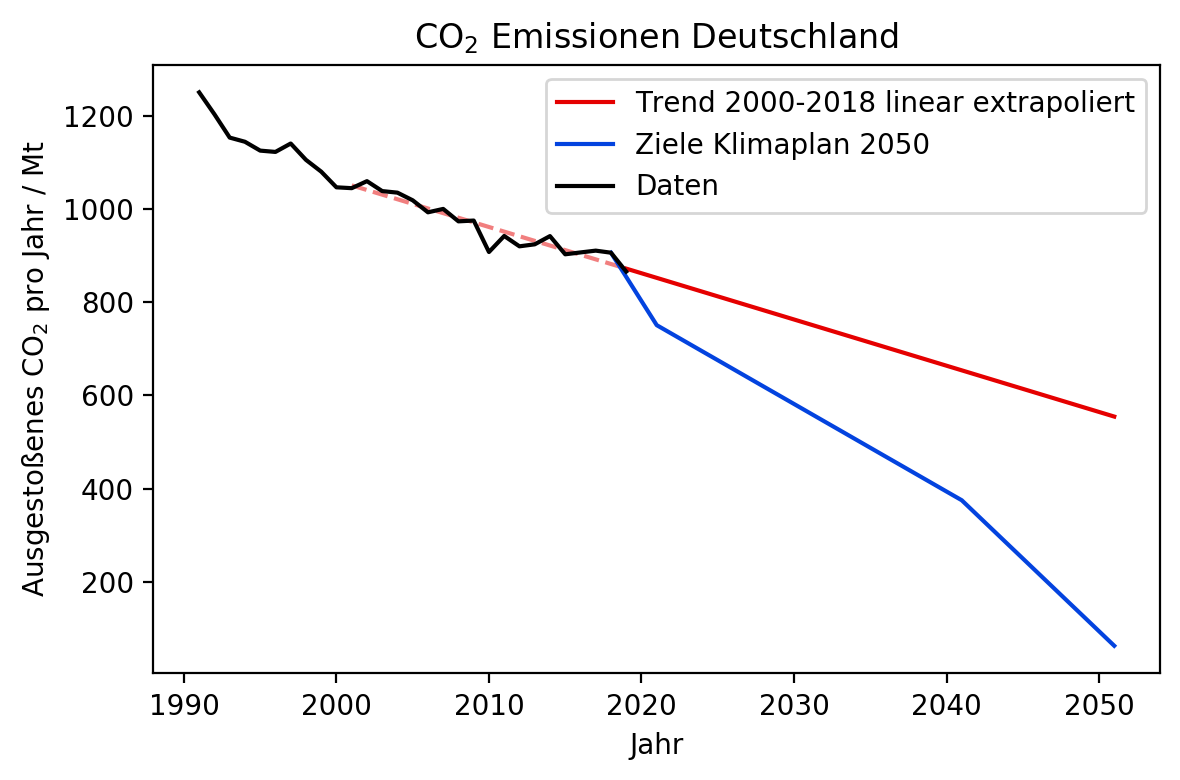

In [5]:
interpolated = df.resample('1Y').interpolate()

plt.figure(dpi=200)


y = df['emissions']['2000': '2019'].dropna()
x = y.index.year
p = Polynomial.fit(x, y, deg=1)


plt.plot(df['2018':].index, p(df['2018':].index.year), color='xkcd:red', label='Trend 2000-2018 linear extrapoliert')
plt.plot(y.index, p(x), color='xkcd:red', ls='--', alpha=0.5)


#  plt.plot(interpolated['paris'], label = 'Kurs nach Paris', color='xkcd:green')
#  plt.plot(interpolated['bmu'], label = 'Aktuelle Schätzung BMU', color='xkcd:orange')
plt.plot(interpolated['target_klimaplan2050'], label='Ziele Klimaplan 2050', color='xkcd:blue')
plt.plot(df['emissions'], label = 'Daten', color='k')

# diff = (interpolated['bmu'] - interpolated['paris']).sum()

# plt.fill_between(
#     interpolated.index,
#     interpolated['paris'],
#     interpolated['bmu'],
#     label=f'Differenz: {diff:.0f} Mt', alpha=0.5, hatch='/'
# )





plt.title('CO$_2$ Emissionen Deutschland')
plt.xlabel('Jahr')
plt.ylabel('Ausgestoßenes CO$_2$ pro Jahr / Mt')
plt.legend()
plt.tight_layout()
plt.savefig('emissions.png', dpi=300)

In [6]:
df.loc['2019':, 'linear_trend'] = p(df['2019':].index.year)

for col in ('target_klimaplan2050', 'linear_trend'):
    df.loc['2017':'2018', col] = df.loc['2017':'2018', 'emissions']

In [7]:
df

,emissions,target_klimaplan2050,linear_trend
year,,,
1990-12-31,1250.993,NaN,NaN
1991-12-31,1203.924,NaN,NaN
1992-12-31,1153.796,NaN,NaN
1993-12-31,1144.857,NaN,NaN
1994-12-31,1125.835,NaN,NaN
1995-12-31,1123.035,NaN,NaN
1996-12-31,1141.085,NaN,NaN
1997-12-31,1106.001,NaN,NaN
1998-12-31,1080.729,NaN,NaN


In [8]:
interpolated = df.resample('1Y').interpolate()

df_rest = interpolated['2017':].cumsum()
df_rest -= df_rest.loc['2017'].values
df_rest.head()

,emissions,target_klimaplan2050,linear_trend
year,,,
2017-12-31,0.0,0.0,0.000000
2018-12-31,866.0,866.0,866.000000
2019-12-31,1732.0,1674.5,1725.294248
2020-12-31,2598.0,2425.5,2577.882745
2021-12-31,3464.0,3157.7,3420.541703


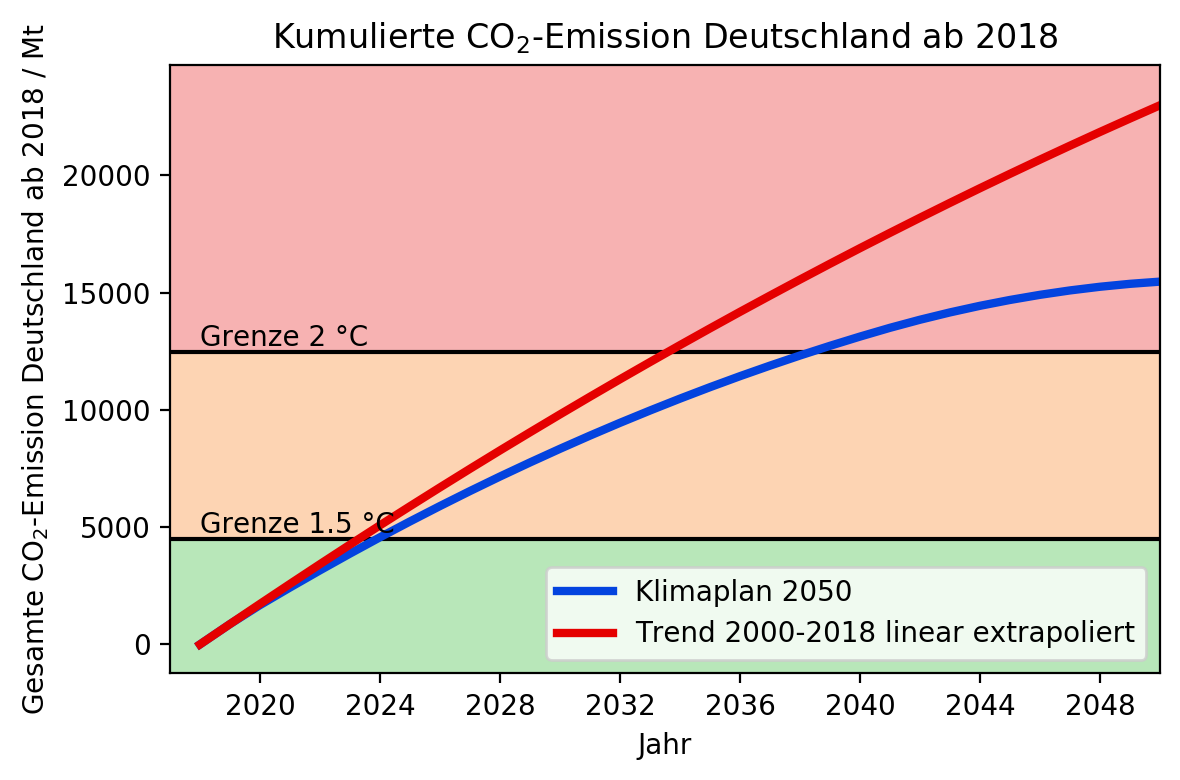

In [9]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1)

targets = {
    '2 °C': budgets.loc[2.0, 'rest_germany'],
    '1.5 °C': budgets.loc[1.5, 'rest_germany'],    
}

start = df_rest.dropna().index.min()



for label, target in targets.items():
    ax.axhline(target, color='k')
    ax.text(start, target, 'Grenze ' + label, va='bottom')

ax.plot(df_rest['target_klimaplan2050'], label='Klimaplan 2050', color='xkcd:blue', lw=3)
ax.plot(df_rest['linear_trend'], label='Trend 2000-2018 linear extrapoliert', color='xkcd:red', lw=3)

ax.set_xlim('2017', '2050')

ax.fill_between(ax.get_xlim(), targets['2 °C'], ax.get_ylim()[1], color='xkcd:red', alpha=0.3, zorder=-1, lw=0)
ax.fill_between(ax.get_xlim(), targets['2 °C'], targets['1.5 °C'], color='xkcd:orange', alpha=0.3, zorder=-1, lw=0)
ax.fill_between(ax.get_xlim(), targets['1.5 °C'], ax.get_ylim()[0], color='xkcd:green', alpha=0.3, zorder=-1, lw=0)

ax.margins(0)

ax.legend(loc='lower right')


ax.set_title('Kumulierte CO$_2$-Emission Deutschland ab 2018')
ax.set_ylabel('Gesamte CO$_2$-Emission Deutschland ab 2018 / Mt')
ax.set_xlabel('Jahr')

fig.tight_layout()
fig.savefig('co2_restbudget.png', dpi=300)